<a href="https://colab.research.google.com/github/amalvarezme/AprendizajeMaquina/blob/main/4_Clasificacion_Clustering_DR/umap_rapids.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Versiones acelaradas con RAPIDS

https://rapids.ai/

In [1]:
#!git clone https://github.com/rapidsai/rapidsai-csp-utils.git

In [2]:
import sklearn
import tensorflow as tf
from tensorflow import keras
import numpy as np

In [3]:
print('keras:',keras.__version__,'tf:',tf.__version__)

keras: 3.8.0 tf: 2.18.0


In [4]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [5]:
import cuml
import cudf
import os.path
from sklearn.preprocessing import MinMaxScaler


from cuml.manifold.umap import UMAP as cuUMAP

print('cuml:',cuml.__version__)

cuml: 25.02.01


In [6]:
cuumap = cuUMAP(n_components=2,             # The dimension of the space to embed into.
                n_neighbors=10,             # The size of local neighborhood (from 1 to 100)
                #local_connectivity=1,       # rho
                random_state=42,
                #n_epochs=100,               # The number of iterations to run
                #learning_rate=0.01          # The learning rate
                )

[2025-05-22 17:01:15.447] [CUML] [info] build_algo set to brute_force_knn because random_state is given


In [7]:
scaX_ = MinMaxScaler()
sca_ = MinMaxScaler()
Z_train = sca_.fit_transform(cuumap.fit_transform(scaX_.fit_transform(X_train.reshape(X_train.shape[0],-1))))

In [8]:
Z_test = sca_.transform(cuumap.transform(scaX_.transform(X_test.reshape(X_test.shape[0],-1))))

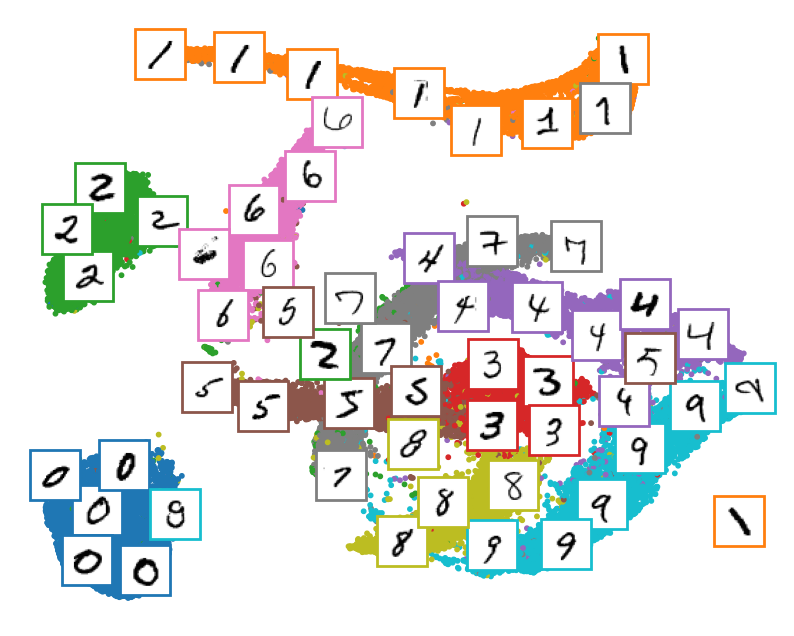

In [9]:
# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
import matplotlib.pyplot as plt
import matplotlib as mpl

plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(Z_train[:, 0], Z_train[:, 1], c=y_train, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(Z_train):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.007: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_train[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_train[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()